In [1030]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## Import Truth CSV

In [1031]:
truth = pd.read_csv('datasets/dl2020/annotation_newfeat_3.csv')
# truth_2 = pd.read_csv('datasets/dl2020/annotation_newfeat_2.csv')


## Input and Scale Pred 

### BEV

In [1066]:
pred = pd.read_csv('/Users/mjin/Desktop/1008/Project/DeepLearning2020/saved/dl2020/dl2020_new_coef3_bev/evaluation_result_bev_efficientdet-d3_20775_val_132_133_0.04_0.5.csv')

pred['x_pred'], pred['y_pred'], pred['w_pred'], pred['h_pred'] = [float(i.split(',')[0][1:]) for i in pred['bbox']], [float(i.split(',')[1]) for i in pred['bbox']], [float(i.split(',')[2]) for i in pred['bbox']], [float(i.split(',')[3][:-1]) for i in pred['bbox']]
pred.category_id -= 1

pred['box_width'] = pred['w_pred']/800*80
pred['box_height'] = pred['h_pred']/800*80

pred['center_x'] = pred['x_pred']/800*80 + pred['box_width']/2 - 40
pred['center_y'] = 40 - pred['y_pred']/800*80 - pred['box_height']/2


### ORI

In [1067]:
# pred = pd.read_csv('/Users/mjin/Desktop/1008/Project/DeepLearning2020/saved/dl2020/dl2020_0503-003830_coef3/evaluation_result_efficientdet-d3_19944_val_132_133_0.05_0.5.csv')

# pred['x_pred'], pred['y_pred'], pred['w_pred'], pred['h_pred'] = [float(i.split(',')[0][1:]) for i in pred['bbox']], [float(i.split(',')[1]) for i in pred['bbox']], [float(i.split(',')[2]) for i in pred['bbox']], [float(i.split(',')[3][:-1]) for i in pred['bbox']]
# pred.category_id -= 1

# pred['box_width'] = pred['w_pred']/612*80
# pred['box_height'] = pred['h_pred']/768*80

# pred['center_x'] = pred['x_pred']/612*80 + pred['box_width']/2 - 40
# pred['center_y'] = 40 - pred['y_pred']/768*80 - pred['box_height']/2


# Get a sample and boxes

In [1068]:
def get_sample_boxes(scene, sample, pred, truth, threshold):
    

    pred = pred[pred.score > threshold]


    pred_sample = pred[pred['scene_id'] == scene][pred['sample_id'] == sample]
    truth_sample = truth[truth['scene'] == scene][truth['sample'] == sample]
    
    truth_corners = truth_sample[['fl_x', 'fr_x', 'bl_x', 'br_x', 'fl_y', 'fr_y','bl_y', 'br_y']].to_numpy()
    
    pred_corners = np.array([pred_sample.center_x + pred_sample.box_width/2, pred_sample.center_x + pred_sample.box_width/2,\
        pred_sample.center_x - pred_sample.box_width/2, pred_sample.center_x - pred_sample.box_width/2,\
        pred_sample.center_y + pred_sample.box_height/2, pred_sample.center_y - pred_sample.box_height/2,\
        pred_sample.center_y + pred_sample.box_height/2, pred_sample.center_y - pred_sample.box_height/2]).T
    
    
    truth_boxes = torch.as_tensor(truth_corners).view(-1, 2, 4)
    pred_boxes = torch.as_tensor(pred_corners).view(-1, 2, 4)
    
    return pred_sample, truth_sample, pred_boxes, truth_boxes
    
    

In [1158]:
pred_sample, truth_sample, pred_boxes, truth_boxes = get_sample_boxes(132, 75, pred, truth, 0.06)

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [1159]:
truth_sample.shape

(26, 35)

In [1160]:
pred_sample.shape

(46, 14)

## Calculate Score

In [1161]:
def compute_iou(box1, box2):
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull
    
    return a.intersection(b).area / a.union(b).area

In [1162]:
def compute_ats_bounding_boxes(boxes1, boxes2):
    num_boxes1 = boxes1.size(0)
    num_boxes2 = boxes2.size(0)

    boxes1_max_x = boxes1[:, 0].max(dim=1)[0]
    boxes1_min_x = boxes1[:, 0].min(dim=1)[0]
    boxes1_max_y = boxes1[:, 1].max(dim=1)[0]
    boxes1_min_y = boxes1[:, 1].min(dim=1)[0]

    boxes2_max_x = boxes2[:, 0].max(dim=1)[0]
    boxes2_min_x = boxes2[:, 0].min(dim=1)[0]
    boxes2_max_y = boxes2[:, 1].max(dim=1)[0]
    boxes2_min_y = boxes2[:, 1].min(dim=1)[0]

    condition1_matrix = (boxes1_max_x.unsqueeze(1) > boxes2_min_x.unsqueeze(0))
    condition2_matrix = (boxes1_min_x.unsqueeze(1) < boxes2_max_x.unsqueeze(0))
    condition3_matrix = (boxes1_max_y.unsqueeze(1) > boxes2_min_y.unsqueeze(0))
    condition4_matrix = (boxes1_min_y.unsqueeze(1) < boxes2_max_y.unsqueeze(0))
    condition_matrix = condition1_matrix * condition2_matrix * condition3_matrix * condition4_matrix

    iou_matrix = torch.zeros(num_boxes1, num_boxes2)
    for i in range(num_boxes1):
        for j in range(num_boxes2):
            if condition_matrix[i][j]:
                iou_matrix[i][j] = compute_iou(boxes1[i], boxes2[j])

    iou_max = iou_matrix.max(dim=0)[0]

    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    total_threat_score = 0
    total_weight = 0
    for threshold in iou_thresholds:
        tp = (iou_max > threshold).sum()
        threat_score = tp * 1.0 / (num_boxes1 + num_boxes2 - tp)
        total_threat_score += 1.0 / threshold * threat_score
        total_weight += 1.0 / threshold

    average_threat_score = total_threat_score / total_weight
    
    return average_threat_score

In [1163]:
compute_ats_bounding_boxes(pred_boxes, truth_boxes)

tensor(0.0148)

## Visualization - Dots and Boxes

In [1164]:
# plt.figure(figsize = (3,3))
# plt.scatter(truth_sample['center_x'], truth_sample['center_y'])
# plt.xlim(-40, 40)
# plt.ylim(-40, 40)
# plt.grid()

In [1165]:
# plt.figure(figsize = (3,3))
# plt.scatter(pred_sample['center_x'], pred_sample['center_y'])
# plt.xlim(-40, 40)
# plt.ylim(-40, 40)
# plt.grid()

In [1166]:
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

In [1167]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)

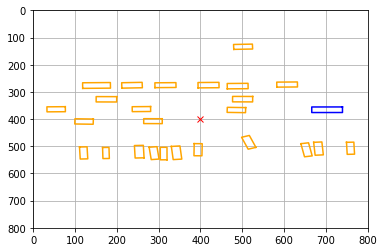

In [1168]:
fig, ax = plt.subplots()

ax.plot(400, 400, 'x', color="red")


for i, bb in enumerate(truth_boxes):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[[int(i) for i in truth_sample.category_id][i]])  
    
ax.set_xlim(0, 800)
ax.set_ylim(800, 0)
plt.grid()

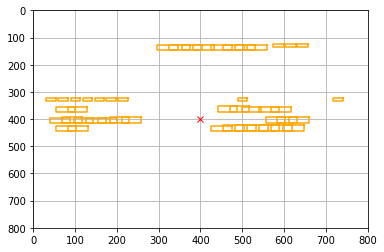

In [1169]:
fig, ax = plt.subplots()

ax.plot(400, 400, 'x', color="red")


for i, bb in enumerate(pred_boxes):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[[int(i) for i in pred_sample.category_id][i]])  
    
ax.set_xlim(0, 800)
ax.set_ylim(800, 0)
plt.grid()

## Get average

In [1109]:
results = []
for scene in [132, 133]:
    for sample in np.arange(0, 126):
        try:
            pred_sample, truth_sample, pred_boxes, truth_boxes = get_sample_boxes(scene, sample, pred, truth, 0.05)
            results.append(compute_ats_bounding_boxes(pred_boxes, truth_boxes))
        except:
            print(scene, sample)
np.mean(results)

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.010044711

# Category_id Distribution

(array([2.3570e+03, 3.1550e+03, 4.0410e+03, 2.1860e+03, 2.6560e+03,
        4.2500e+03, 2.3936e+04, 1.1180e+04, 2.2200e+03, 7.1500e+02,
        5.9900e+02, 2.9800e+02, 5.6500e+02, 3.5600e+02, 2.4700e+02,
        4.6900e+02, 1.9700e+02, 9.0000e+01, 1.0200e+02, 1.4000e+01,
        9.0000e+00, 2.3000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 9.0000e+00, 3.9000e+01]),
 array([ 0.22330811,  0.88720345,  1.55109879,  2.21499414,  2.87888948,
         3.54278482,  4.20668016,  4.8705755 ,  5.53447085,  6.19836619,
         6.86226153,  7.52615687,  8.19005221,  8.85394755,  9.5178429 ,
        10.18173824, 10.84563358, 11.50952892, 12.17342426, 12.83731961,
        13.50121495, 14.16511029, 14.82900563, 15.49290097, 16.15679632,
        16.82069166, 17.484587  , 18.14848234, 18.81237768, 19.47627303,
        20.14016837]),
 <a list of 30 Patch objects>)

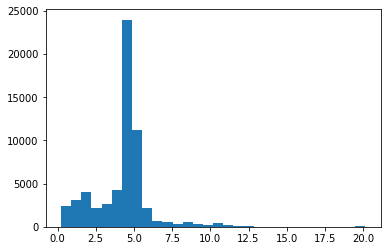

In [986]:
plt.hist(truth.box_width, bins = 30)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 7.000e+00, 3.000e+01, 1.290e+02, 5.660e+02, 1.086e+03,
        1.099e+03, 6.750e+02, 4.820e+02, 4.530e+02, 3.590e+02, 2.440e+02,
        2.690e+02, 3.580e+02, 4.130e+02, 4.280e+02, 5.700e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([5.24235345, 5.29884501, 5.35533657, 5.41182813, 5.4683197 ,
        5.52481126, 5.58130282, 5.63779438, 5.69428594, 5.7507775 ,
        5.80726906, 5.86376062, 5.92025218, 5.97674374, 6.0332353 ,
        6.08972687, 6.14621843, 6.20270999, 6.25920155, 6.31569311,
        6.37218467, 6.42867623, 6.48516779, 6.54165935, 6.59815091,
        6.65464247, 6.71113404, 6.7676256 , 6.82411716, 6.88060872,
        6.93710028]),
 <a list of 30 Patch objects>)

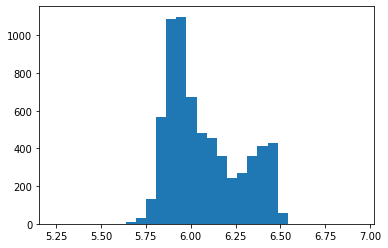

In [987]:
plt.hist(pred.box_width, bins = 30)

In [166]:
pred.columns, truth.columns

(Index(['Unnamed: 0', 'scene_id', 'sample_id', 'category_id', 'score', 'bbox',
        'x_pred', 'y_pred', 'w_pred', 'h_pred', 'box_width', 'box_height',
        'center_x', 'center_y'],
       dtype='object'),
 Index(['Unnamed: 0', 'scene', 'sample', 'action', 'category', 'fl_x', 'fr_x',
        'bl_x', 'br_x', 'fl_y', 'fr_y', 'bl_y', 'br_y', 'category_id',
        'action_id', 'new_scene', 'front_left', 'front', 'front_right',
        'back_left', 'back', 'back_right', 'distance', 'center_x', 'center_y',
        'box_width', 'box_height', 'scaled_x', 'scaled_y', 'scaled_box_width',
        'scaled_box_height', 'bev_x', 'bev_y', 'bev_box_width',
        'bev_box_height'],
       dtype='object'))

In [163]:
truth.shape

(59715, 35)